<a href="https://colab.research.google.com/github/aycaaozturk/Nail-Melanoma-Project/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages
!pip install tensorflow opencv-python-headless

# Import libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf    # ML Library
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')



# Set dataset paths
train_dir = '/content/drive/My Drive/yolov8 format all datasets/nail_dataset/train'
test_dir = '/content/drive/My Drive/yolov8 format all datasets/nail_dataset/test'

Mounted at /content/drive


In [ ]:
# Image parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224     # Input image size
BATCH_SIZE = 32

# Data generators
#for preprocessing and data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),   # resize to 224*224
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=42
)

# Validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=42
)

print(train_generator.class_indices)


Found 1700 images belonging to 2 classes.
Found 486 images belonging to 2 classes.


In [ ]:
# Define the model using EfficientNetB0

#base model is a feature extractor
base_model = tf.keras.applications.EfficientNetB0(   # loads the pretrained base model from keras
    include_top=False,                               # Removes the model’s original classification head, we replace with ours for 2 classes (healthy vs melanoma)
    weights='imagenet',                             # Loads the pre-trained weights learned from ImageNet.
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze the base model
base_model.trainable = False    # dont update the layers -> frozen

# Create the full model
model = tf.keras.Sequential([                    #creates a stack of layers, consists of 3 parts
    base_model,                                  # feature extractor
    tf.keras.layers.GlobalAveragePooling2D(),      #summarizes those features  (from 2d spatial features ->> to 1d vector)            --->>>   my classification
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification -> predicts the class                                     --->>>          head

                                                 #Dense(1, sigmoid) predicts a probability -> melanoma or healthy
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer='adam',             # adam: to minimize the errors, it adjusts the lr dynamically
              loss='binary_crossentropy',   # defines how the model measures error
             metrics=[
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
])

# callbacks: functions, which are called automatically (at certain moments) during training
# they can intervene and evaluate the process, like saving the best model, stopping the training, changing the learning rate

# to reduce runtime and overfitting

callbacks=[
  tf.keras.callbacks.ModelCheckpoint('best.keras', save_best_only=True, monitor='val_loss'),   # saves the model when the val loss is the lowest  (saves the best)
  tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'), # stops the training if val loss doesnt get better through the epochs
  tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor='val_loss')             # if val loss doesnt get better for 2 epochs -> multiply lr x 0.5
]

class_weight = {0: 1.33, 1: 4.00}   # if healthy 0, melanoma 1   ->>> so that its sensitive to the minority class (melanoma class)

# Train the model
history = model.fit(
    train_generator,                                         # it feeds images and labels to the model
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=10,  # You can adjust the number of epochs
    callbacks=callbacks,
    class_weight=class_weight
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1385s 26s/step - accuracy: 0.7767 - auc: 0.4954 - loss: 0.5490 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7458 - val_auc: 0.5000 - val_loss: 0.5727 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
 1/53 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8125 - auc: 0.5929 - loss: 0.4827 - precision: 0.0000e+00 - recall: 0.0000e+00

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.8125 - auc: 0.5929 - loss: 0.4827 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7458 - val_auc: 0.5000 - val_loss: 0.5729 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 420ms/step - accuracy: 0.7989 - auc: 0.5001 - loss: 0.5035 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7479 - val_auc: 0.5000 - val_loss: 0.5778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8438 - auc: 0.3889 - loss: 0.4408 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7479 - val_auc: 0.5028 - val_loss: 0.5778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 415ms/step - accuracy: 0.7802 - auc: 0.5001 - loss: 0.5281 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7458 - val_auc: 0.5000 - val_loss: 0.5708 - val_precision: 0.0000e+00 - va

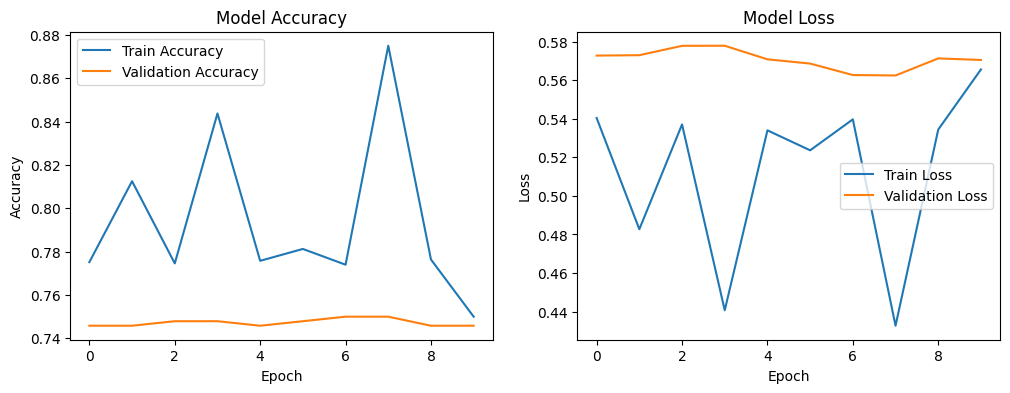

In [ ]:
# Save the model
model.save('/content/nail_classifier.h5')

# Plotting training and validation accuracy and loss
def plot_metrics(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

plot_metrics(history)

# Function for loading and preprocessing an image
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img


16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


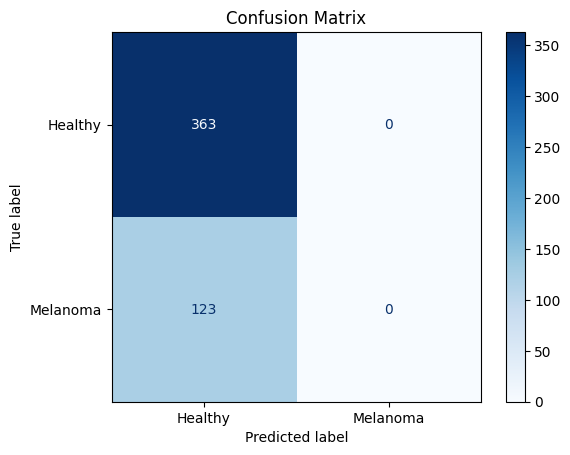

              precision    recall  f1-score   support

     Healthy       0.75      1.00      0.86       363
    Melanoma       0.00      0.00      0.00       123

    accuracy                           0.75       486
   macro avg       0.37      0.50      0.43       486
weighted avg       0.56      0.75      0.64       486



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Confusion Matrix and other Metrics

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Predict on validation data
true_labels = validation_generator.classes
pred_probs = model.predict(validation_generator)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Melanoma'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Detailed metrics
print(classification_report(true_labels, pred_labels, target_names=['Healthy', 'Melanoma']))

In [ ]:
from google.colab import files
import shutil

# Upload an image file
uploaded = files.upload()

# Save the uploaded image to a temporary location
for filename in uploaded.keys():
    # Use the uploaded file directly
    sample_image_path = filename
    print(f'Uploaded file: {sample_image_path}')

# Load and preprocess the uploaded image
sample_image = load_and_preprocess_image(sample_image_path)

# Make predictions
prediction = model.predict(sample_image)
predicted_class = 'healthy' if prediction[0][0] < 0.5 else 'melanoma'
print(f'The predicted class is: {predicted_class}')
